#### Strategy based on ARMA model

Idea：

From the baseline approach, we can easily see that it may not be a good idea to assume the spread series has a steady mean. Thus it is more appropriate to consider a model allowing shifting mean when fitting the spread. And ARMA model is one of the easiest and popular ones to try.

(1) Fit the spread series with ARMA model.

(2) Design the trading rule based on the mean-reverting behaviors of ARMA process. 

#### 1. Fitting Spread with ARMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [25]:
train_spread = pd.read_csv("CADF_spread.csv",index_col=0)
train_spread.head()

,spread
日期,
2020-04-24 10:52:00,1.072740
2020-04-24 10:53:00,1.072507
2020-04-24 10:54:00,1.073019
2020-04-24 10:55:00,1.072737
2020-04-24 10:56:00,1.072676


In [29]:
#读入测试数据
test_spread = pd.read_csv("CADF_test_spread.csv",index_col=0)
test_spread["spread"]= test_spread["test_spread"]
test_spread.head()

,test_spread,spread
日期,,
2020-11-09 13:00:00,1.057828,1.057828
2020-11-09 13:01:00,1.058153,1.058153
2020-11-09 13:02:00,1.058155,1.058155
2020-11-09 13:03:00,1.058430,1.058430
2020-11-09 13:04:00,1.057988,1.057988


In [42]:
# 制作统一spread，方便后面操作
spread = pd.concat([train_spread["spread"],test_spread["spread"]],axis=0)
spread.head()

日期
2020-04-24 10:52:00    1.072740
2020-04-24 10:53:00    1.072507
2020-04-24 10:54:00    1.073019
2020-04-24 10:55:00    1.072737
2020-04-24 10:56:00    1.072676
Name: spread, dtype: float64

[1.         0.9989772  0.99834373 0.99770604 0.99707813 0.99644417
 0.99580306 0.9951648  0.99454142 0.99393791 0.99334097 0.992735
 0.99213321 0.99151858 0.99088876 0.99026153 0.98961849 0.9889735
 0.98831231 0.98765115 0.98697117]
[ 1.00000000e+00  9.99058015e-01  1.99700880e-01  3.88326206e-02
  1.30777226e-02  1.13961917e-03 -6.02037258e-03 -1.54486920e-03
  6.78485159e-03  1.54633826e-02  8.70910652e-03 -1.06889718e-03
  8.98285361e-04 -4.69551391e-03 -1.04382973e-02 -2.77441964e-03
 -1.03491090e-02 -3.50541188e-03 -1.00026587e-02 -3.81983939e-03
 -1.03087154e-02]


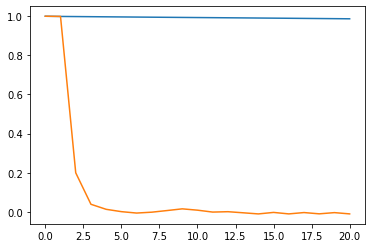

In [43]:
# plot the autoregressiveness
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(train_spread["spread"], nlags=20)
lag_pacf = pacf(train_spread["spread"], nlags=20, method='ols')

print(lag_acf) 
print(lag_pacf)

plt.plot(lag_acf) # it's high simply because the high-frequent nature
plt.plot(lag_pacf)

In [38]:
from statsmodels.tsa.arima_model import ARIMA

In [48]:
# A(1,1) is the most robust choice proved by past research
model = ARIMA(spread, order=(2,1,0))
model = model.fit()
print(model.summary())
resid = model.resid
mse = np.sqrt(np.sum(resid*resid))/np.std(resid)
print(mse)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                             ARIMA Model Results                              
Dep. Variable:               D.spread   No. Observations:                37920
Model:                 ARIMA(2, 1, 0)   Log Likelihood              249403.530
Method:                       css-mle   S.D. of innovations              0.000
Date:                Mon, 19 Apr 2021   AIC                        -498799.061
Time:                        00:32:31   BIC                        -498764.888
Sample:                             1   HQIC                       -498788.217
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            2.67e-07   1.41e-06      0.190      0.849   -2.49e-06    3.02e-06
ar.L1.D.spread    -0.1932      0.005    -37.638      0.000      -0.203      -0.183
ar.L2.D.spread    -0.0367      0.005

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


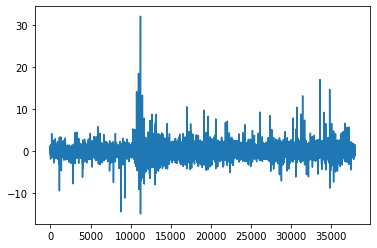

In [54]:
# 根据差分复原预测值
diff = model.predict().values
lag = spread.values[:len(diff)]
fitted = diff + lag 
# 计算残差
residual = spread.values[1:] - fitted
# 转化为z-score
z_score = (residual - np.mean(residual))/np.std(residual)
plt.plot(z_score)

#### 2. 策略设计

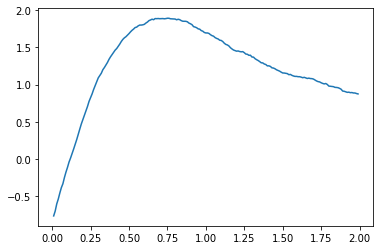

In [67]:
# 以下依旧用类似的方式建立策略，只是信号改为拟合后的残差
def calculate_profit(spread,z_score,threshold,transaction_cost=0.3/10000):
    turn_over = 0
    # 计算每期价差的变化，也即log return
    log_ret = spread.diff(1).shift(1).values
    spread_score = z_score
    # 一开始空仓，只持有现金
    # 当价差大于正threshold的时候，持有负的头寸
    # 当价差小于负threshold的时候，持有正的头寸
    # 其余时间不调整头寸
    portfolio_return = []
    now_pos = 0
    past_pos = 0
    for i in range(1,len(spread_score)):
        past_pos = now_pos
        if spread_score[i] > threshold:
            now_pos = 1
        if spread_score[i] < -threshold:
            now_pos = -1
        if now_pos == past_pos:
            portfolio_return.append(log_ret[i]*now_pos)
        else:
            portfolio_return.append(log_ret[i]*now_pos-transaction_cost)
            # 调整头寸时扣除交易费用
        
    portfolio_return = portfolio_return[1:]
    total_ret = np.sum(portfolio_return)
    IR = total_ret/np.std(portfolio_return)
        
    return total_ret,IR, portfolio_return

profit_list = []
IR_list = []
threshold_list = [0.01* n for n in range(1,200)]
for threshold in threshold_list:
    #print(threshold)
    profit = calculate_profit(train_spread.iloc[1:,0],z_score[0:len(train_spread)-1],threshold)
    profit_list.append(profit[0])
    IR_list.append(profit[1])
    #print(threshold)
    #print(profit[0])
plt.plot(threshold_list,profit_list)
# bellow is the plot of profit given different threshold

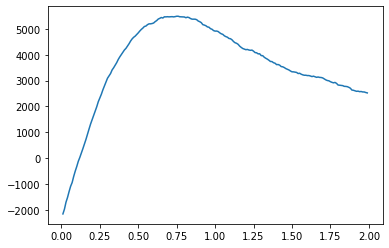

In [68]:
plt.plot(threshold_list,IR_list)

In [69]:
print(threshold_list[np.argmax(profit_list)])
print(threshold_list[np.argmax(IR_list)])
# 最佳值都在0.75取到

0.75
0.75


profit:
1.8937694932239242
IF Ratio:
5484.903178117568


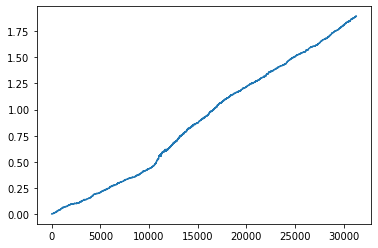

In [71]:
result = calculate_profit(train_spread.iloc[1:,0],z_score[0:len(train_spread)-1],0.75)
print("profit:")
print(result[0])
print("IF Ratio:")
print(result[1]) # that ratio is not annualized
profit = pd.Series(result[2])
plt.plot(profit.cumsum()) # 收益序列

#### 4. 测试策略

profit:
0.4469824608713971
IF Ratio:
1413.228279934924


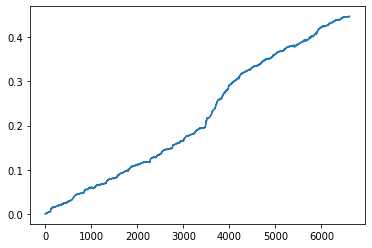

In [73]:
result = calculate_profit(test_spread.iloc[:,0],z_score[len(train_spread)-1:],0.75)
print("profit:")
print(result[0])
print("IF Ratio:")
print(result[1]) # that ratio is not annualized
test_profit = pd.Series(result[2])
plt.plot(test_profit.cumsum()) # 收益序列

In [74]:
# 记录结果
profit.to_csv("ARMA_train_profit.csv")
test_profit.to_csv("ARMA_test_profit.csv")